# Inspecting knowledge base of training data <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Background
Prior to training a machine learning classifier, it can be useful to understand which of the feature layers we have computed are actually useful for distinguishing between the classes. The feature layers that the model is trained on form the `knowledge base` of the algorithm; we can explore this knoweldge base using class-specific box plots (these summarise the distributions of each feature layer), and through a dimensionality reduction approach called `principal-components analysis`. 


## Description

Using the training data written to file in the previous notebook [1_Extract_training_data](1_Extract_training_data.ipynb), this notebook will plot class-specific box-plots for each of the feature layers in the training data, before calcu;ating and plotting the first two prinicpal components of the dataset as a scatter plot.

***

## Load modules

In [6]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `class_dict`: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. `{'crop': 1., 'noncrop': 0.}`)
* `field`: This is the name of column in the original training data shapefile that contains the class labels. This is provided simply so we can remove this attribute before we plot the data

In [7]:
training_data = "results/training_data/test_training_data.txt"

class_dict = {'crop':1, 'noncrop':0}

field = 'class'

## Import training data

In [8]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

## Data Wrangling

In [9]:
dfs = {}
for key, value in class_dict.items():
    print(key)
    
    # extract values for class from training data
    arr = model_input[model_input[:,0]==value]
    
    # create a pandas df for ease of use later
    df = pd.DataFrame(arr).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    
    # Normalise 0-1 for plotting purposes
    df = (df-df.min())/(df.max()-df.min())
    
    dfs.update({key:df})

crop
noncrop


## Feature layer boxplots

TODO:
- figure out how to automate the boxplot offsets...changes with number of classes
        
        if len(dfs) == 2:
            offsets = [-.2, 0.2]
            width = 0.4

        if len(dfs) == 3:
            offsets = [-.2, 0.66, 0.2]
            width = 0.4

        if len(dfs) == 4:
            offsets = [-.2, -0.1, 0., 0.1]
            width = 0.4

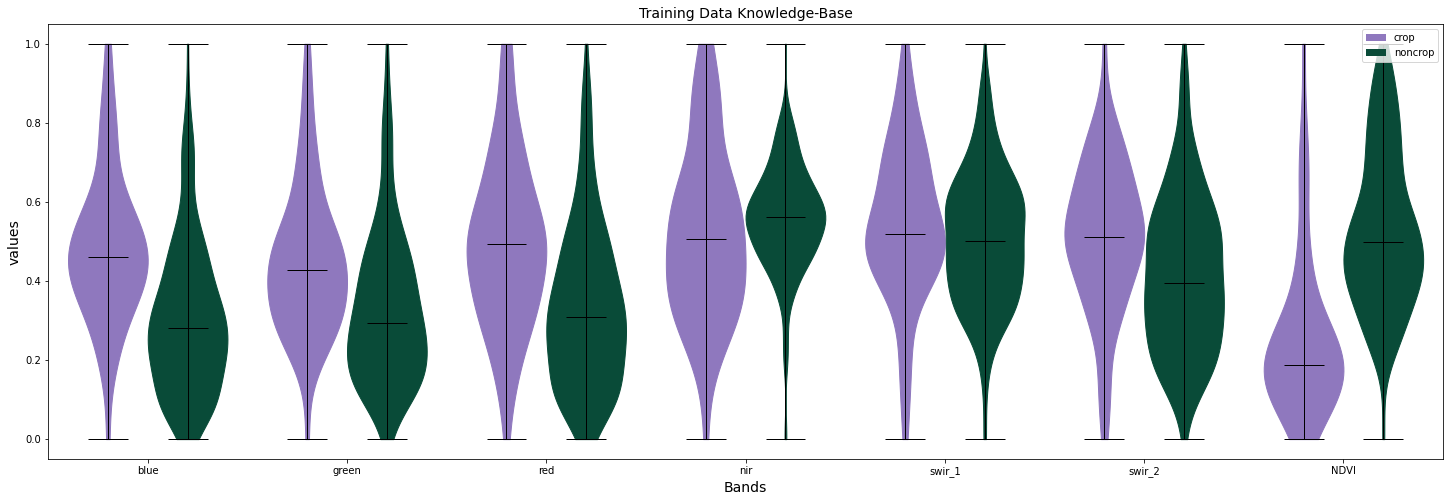

In [41]:
#generate a random list of colors same length as num of classes 
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(dfs))

#generate list of offsets for plotting that are the same lenght as num of classes
offsets = [-.2, 0.2]

fig, ax = plt.subplots(figsize=(25,8))

for key, color, offset in zip(dfs,colors, offsets):
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1])+offset, widths=0.4,
                      )
    
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

        
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("values", fontsize=14)
ax.set_xlabel("Bands", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs], loc='upper right')

plt.show()

---
## Principal Component Analysis

 Need to standardize the values before conducting the PCA.  Couple of ways to do this, using `StandardScaler` for now i.e. `x-u/s`

In [42]:
# Put all the model TD into a pandas dataframe
all_data = pd.DataFrame(model_input).rename(columns={i:column_names[i] for i in range(0,len(column_names))})

In [43]:
# Separating out the features
x = all_data.loc[:, column_names[1:]].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [44]:
#conduct the PCA
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(x)

#add back to df
pca_df = pd.DataFrame(data = pca_fit,
                      columns = ['PC1', 'PC2'])

# concat with classes
df = pd.concat([pca_df, all_data[['class']]], axis = 1)

In [45]:
a,b = pca.explained_variance_ratio_
print("Variance explained by two principal components = " + str(round((a+b)*100, 2))+" %")

Variance explained by two principal components = 95.64 %


### Plot the principal components

Only plot a random subsample of the dataset as its huge

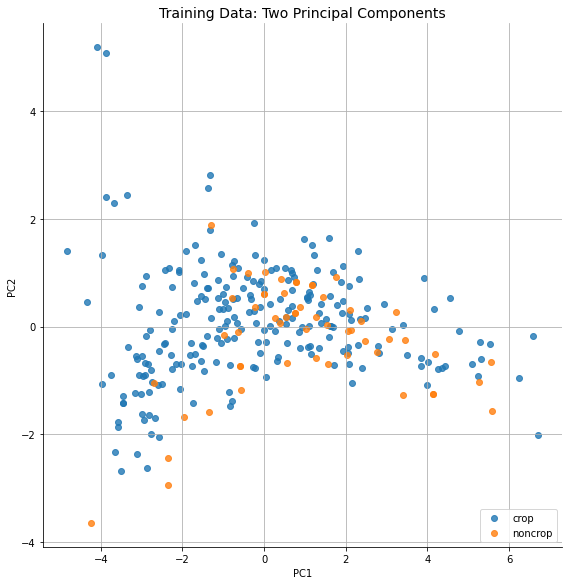

In [46]:
sns.lmplot(x="PC1", y="PC2",
           data=df,
           fit_reg=False,
           hue='class',
           legend=False,
           height=8,
          )

plt.legend(tuple(key for key in dfs), loc='lower right')
plt.title('Training Data: Two Principal Components', fontsize=14)
plt.grid();